In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import random as rn
warnings.filterwarnings("ignore")

In [2]:

# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [3]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [4]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [5]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [6]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [7]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [8]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [9]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [10]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [11]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [12]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [13]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [14]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [15]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [16]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [17]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [18]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [19]:
def plot_performance_metrics(df , colors=None, labels = None, y_min = 0.0, frame_color = 'gray', frame_width = 0.5, x_label_rotation = 45, tick_size = 14,legend_fontsize = 12,
                            legend_labels = None, legend_loc = 'upper center', legend_bbox_to_anchor=(0.5, -0.2), legend_ncol=4, save=False, save_path=None):

    # Default values
    default_colors = ['#5E0B8A', '#00A7E1', '#BDDA57', '#FF8C00']
    default_labels = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]
    default_legend_labels =['scATAcat', 'Seurat label transfer', 'Cellcano', 'EpiAnno']

    # Use default if None is passed
    colors = default_colors if colors is None else colors
    labels = default_labels if labels is None else labels
    legend_labels = default_legend_labels if legend_labels is None else legend_labels
  
    df.columns = labels
    df.index = legend_labels
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    n_bins = 100  # Increase this number for a smoother gradient
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    ax = df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=cmap)
    ax.set_ylim(ymin=y_min)
    # Change plot frame to gray and adjust linewidth
    spine_color = 'gray'
    linewidth = frame_width # Adjust the linewidth as needed
    for spine in ax.spines.values():
        spine.set_color(spine_color)
        spine.set_linewidth(linewidth)
    ax.legend(legend_labels,fontsize=legend_fontsize, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=False, shadow=False, ncol=legend_ncol, frameon=False)
    plt.xticks(rotation=x_label_rotation)
    plt.tick_params(axis='both', which='major', labelsize=tick_size)

    if save == False:
        plt.show()
    else:
        if save_path == None:
            print("specify the save_path directory")
        else:
            plt.savefig(save_path, bbox_inches='tight', transparent=True)

### silver ground truth annotations - from original publication


In [20]:
ground_truth_annotations = pd.read_csv("../../../data/Granja2019/BMMC_D6T1/03_cellIDs_and_annotations/metadata.csv")

In [21]:
ground_truth_annotations.shape

(12394, 10)

In [22]:
ground_truth_annotations = ground_truth_annotations[["BioClassification", "Barcode"]]
ground_truth_annotations[['cluster_id', 'annotation']] = ground_truth_annotations['BioClassification'].str.split('_', n=1, expand=True)
ground_truth_annotations.index=ground_truth_annotations['Barcode']
ground_truth_annotations.index.name = None
ground_truth_annotations.columns = ["BioClassification","cell_IDs","cluster_id","annotation"]

In [23]:
set(ground_truth_annotations.annotation)

{'B',
 'CD14.Mono.1',
 'CD14.Mono.2',
 'CD4.M',
 'CD4.N1',
 'CD4.N2',
 'CD8.CM',
 'CD8.EM',
 'CD8.N',
 'CLP.1',
 'CLP.2',
 'CMP.LMPP',
 'Early.Baso',
 'Early.Eryth',
 'GMP',
 'GMP.Neut',
 'HSC',
 'Late.Eryth',
 'NK',
 'Plasma',
 'Pre.B',
 'Unk',
 'cDC',
 'pDC'}

In [24]:
ground_truth_renaming_dict={'B':'Bcell',
 'CD14.Mono.1':'Mono',
 'CD14.Mono.2':'Mono',
 'CD4.M':'CD4Tcell',
 'CD4.N1':'CD4Tcell',
 'CD4.N2':'CD4Tcell',
 'CD8.CM':'CD8Tcell',
 'CD8.EM':'CD8Tcell',
 'CD8.N':'CD8Tcell',
 'Early.Baso':'Basofil',
 'GMP':'GMP',
 'HSC':'HSC/MPP',
 'NK':'NKcell',
 'Plasma':'Plasmacell',
 'Unk':'Unknown',
 'cDC':'cDC',
 'pDC':'pDC',
 'CLP.1': 'CLP',
 'CLP.2': 'CLP',
 'CMP.LMPP': 'CMP/LMPP',
 'Early.Eryth': 'Ery',
 'GMP.Neut': 'GMP',
 'Late.Eryth': 'Ery',
 'Pre.B': 'CLP'}

In [25]:
ground_truth_annotations= ground_truth_annotations.assign(ground_truth_annotations_simplified=list(ground_truth_annotations['annotation'].map(ground_truth_renaming_dict)))
ground_truth_annotations.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
CACCTGTTCTTTATCG-1,11_CD14.Mono.1,CACCTGTTCTTTATCG-1,11,CD14.Mono.1,Mono
GCCCAGAAGTGTCACT-1,16_Pre.B,GCCCAGAAGTGTCACT-1,16,Pre.B,CLP
CCTTAATCAGTATACC-1,11_CD14.Mono.1,CCTTAATCAGTATACC-1,11,CD14.Mono.1,Mono
GTGCCAGTCAAGGCAG-1,13_Unk,GTGCCAGTCAAGGCAG-1,13,Unk,Unknown
TGTGTCCAGAAAGCAG-1,11_CD14.Mono.1,TGTGTCCAGAAAGCAG-1,11,CD14.Mono.1,Mono


In [26]:
set(ground_truth_annotations.ground_truth_annotations_simplified)

{'Basofil',
 'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP/LMPP',
 'Ery',
 'GMP',
 'HSC/MPP',
 'Mono',
 'NKcell',
 'Plasmacell',
 'Unknown',
 'cDC',
 'pDC'}

In [27]:
ground_truth_annotations.ground_truth_annotations_simplified.value_counts()

ground_truth_annotations_simplified
CD4Tcell      2846
Mono          2789
GMP           1503
CLP           1244
CD8Tcell      1052
Unknown        616
Bcell          567
Ery            376
pDC            346
NKcell         313
CMP/LMPP       293
Basofil        190
HSC/MPP        125
cDC            111
Plasmacell      23
Name: count, dtype: int64

In [28]:
ground_truth_annotations.shape

(12394, 5)

In [29]:
ground_truth_annotations_known = ground_truth_annotations[ground_truth_annotations['ground_truth_annotations_simplified']!= "Unknown"]

In [30]:
ground_truth_annotations_known.shape

(11778, 5)

### seurat annotations

In [31]:
seurat_labelTransfer_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_seurat_label_transfer/Granja2019_BMMC_seurat_label_transfer_annotations.csv")
seurat_labelTransfer_annotations.columns = ["cell_IDs", "label_transfer_annotations"]
seurat_labelTransfer_annotations.index = seurat_labelTransfer_annotations.cell_IDs
seurat_labelTransfer_annotations.index.name = None
seurat_labelTransfer_annotations

,cell_IDs,label_transfer_annotations
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,CD8 Naive
TATGTTCAGGGTTCCC-1,TATGTTCAGGGTTCCC-1,CD14 Mono
GTTATGGCAACTAGAA-1,GTTATGGCAACTAGAA-1,CD14 Mono
GTAGGAGCATTATGGC-1,GTAGGAGCATTATGGC-1,CD14 Mono
CCCACATGTCTCGGGT-1,CCCACATGTCTCGGGT-1,Prog_RBC
...,...,...
TTAGGTGGTGGCCTTG-1,TTAGGTGGTGGCCTTG-1,NK
ACCGAATTCTGATCTT-1,ACCGAATTCTGATCTT-1,CD14 Mono
GCTTGCTTCGAGGTCC-1,GCTTGCTTCGAGGTCC-1,CD8 Naive
TTGACGAGTTGGGAAC-1,TTGACGAGTTGGGAAC-1,Naive B


In [32]:
seurat_annotations = ['CD4 Naive', 'Prog_B 1', 'CD4 Memory', 'Prog_RBC', 'CD8 Memory_2', 'Memory B', 'NK', 'CD14 Mono', 'CD8 Naive', 'CD8 Effector_2', 'Naive B', 'HSC', 'MAIT', 'pDC', 'GMP', 'CD16 Mono', 'gdT', 'Prog_B 2', 'LMPP', 'CD8 Effector_1', 'Prog_DC', 'Plasmablast', 'cDC2', 'Prog_Mk', 'CD56 bright NK', 'CD8 Memory_1', 'Treg']
seurat_annotations_simplified = ['CD4Tcell', "CLP", 'CD4Tcell', "MEP", "CD8Tcell", "Bcell", "NKcell", "Mono", "CD8Tcell", "CD8Tcell", "Bcell", 'HSC/MPP', 'MAIT', 'pDC', 'GMP', "Mono", 'gdT', 'CLP', 'CMP/LMPP', 'CD8Tcell', "GMP", 'Plasmablast', 'cDC', "MEP", "NKcell", 'CD8Tcell', 'Treg']

seurat_annotations_and_simplified_dict = dict(zip(seurat_annotations, seurat_annotations_simplified))

print(seurat_annotations_and_simplified_dict)


{'CD4 Naive': 'CD4Tcell', 'Prog_B 1': 'CLP', 'CD4 Memory': 'CD4Tcell', 'Prog_RBC': 'MEP', 'CD8 Memory_2': 'CD8Tcell', 'Memory B': 'Bcell', 'NK': 'NKcell', 'CD14 Mono': 'Mono', 'CD8 Naive': 'CD8Tcell', 'CD8 Effector_2': 'CD8Tcell', 'Naive B': 'Bcell', 'HSC': 'HSC/MPP', 'MAIT': 'MAIT', 'pDC': 'pDC', 'GMP': 'GMP', 'CD16 Mono': 'Mono', 'gdT': 'gdT', 'Prog_B 2': 'CLP', 'LMPP': 'CMP/LMPP', 'CD8 Effector_1': 'CD8Tcell', 'Prog_DC': 'GMP', 'Plasmablast': 'Plasmablast', 'cDC2': 'cDC', 'Prog_Mk': 'MEP', 'CD56 bright NK': 'NKcell', 'CD8 Memory_1': 'CD8Tcell', 'Treg': 'Treg'}


In [33]:
seurat_labelTransfer_annotations['seurat_annotations_simp'] =list(seurat_labelTransfer_annotations["label_transfer_annotations"].map(seurat_annotations_and_simplified_dict))
seurat_labelTransfer_annotations.columns=["cell_IDs", "label_transfer_annotations", "label_transfer_annotations_simplified"]

In [34]:
seurat_labelTransfer_annotations

,cell_IDs,label_transfer_annotations,label_transfer_annotations_simplified
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,CD8 Naive,CD8Tcell
TATGTTCAGGGTTCCC-1,TATGTTCAGGGTTCCC-1,CD14 Mono,Mono
GTTATGGCAACTAGAA-1,GTTATGGCAACTAGAA-1,CD14 Mono,Mono
GTAGGAGCATTATGGC-1,GTAGGAGCATTATGGC-1,CD14 Mono,Mono
CCCACATGTCTCGGGT-1,CCCACATGTCTCGGGT-1,Prog_RBC,MEP
...,...,...,...
TTAGGTGGTGGCCTTG-1,TTAGGTGGTGGCCTTG-1,NK,NKcell
ACCGAATTCTGATCTT-1,ACCGAATTCTGATCTT-1,CD14 Mono,Mono
GCTTGCTTCGAGGTCC-1,GCTTGCTTCGAGGTCC-1,CD8 Naive,CD8Tcell
TTGACGAGTTGGGAAC-1,TTGACGAGTTGGGAAC-1,Naive B,Bcell


### scATAcat annotations

In [35]:
scATAcat_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_scATAcat/outputs_pairwise/scATAcat_annotations.csv")
scATAcat_annotations.index = scATAcat_annotations['cell_IDs']
scATAcat_annotations.index.name = None
scATAcat_annotations.columns = ['cell_IDs','leiden_1','scATAcat_annotation']
scATAcat_annotations

,cell_IDs,leiden_1,scATAcat_annotation
AAACGAAAGAACCATA-1,AAACGAAAGAACCATA-1,13,GMP
AAACGAAAGAGAGGTA-1,AAACGAAAGAGAGGTA-1,1,CD4Tcell
AAACGAAAGCACGTAG-1,AAACGAAAGCACGTAG-1,14,CLP
AAACGAAAGGAAACTT-1,AAACGAAAGGAAACTT-1,2,CD4Tcell
AAACGAAAGGCAGTGT-1,AAACGAAAGGCAGTGT-1,1,CD4Tcell
...,...,...,...
TTTGTGTTCAGTCAAC-1,TTTGTGTTCAGTCAAC-1,16,CMP
TTTGTGTTCCAAGAGG-1,TTTGTGTTCCAAGAGG-1,2,CD4Tcell
TTTGTGTTCCAGAATC-1,TTTGTGTTCCAGAATC-1,9,CD8Tcell
TTTGTGTTCCCGTAGG-1,TTTGTGTTCCCGTAGG-1,2,CD4Tcell


In [36]:
set(scATAcat_annotations.scATAcat_annotation)

{'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP',
 'GMP',
 'MEP',
 'Mono',
 'NKcell',
 'pDC'}

In [37]:
scATAcat_annotations.scATAcat_annotation = scATAcat_annotations.scATAcat_annotation.replace({"CMP": "CMP/LMPP","LMPP": "CMP/LMPP", "HSC": "HSC/MPP", "MPP": "HSC/MPP"})

In [38]:
scATAcat_annotations

,cell_IDs,leiden_1,scATAcat_annotation
AAACGAAAGAACCATA-1,AAACGAAAGAACCATA-1,13,GMP
AAACGAAAGAGAGGTA-1,AAACGAAAGAGAGGTA-1,1,CD4Tcell
AAACGAAAGCACGTAG-1,AAACGAAAGCACGTAG-1,14,CLP
AAACGAAAGGAAACTT-1,AAACGAAAGGAAACTT-1,2,CD4Tcell
AAACGAAAGGCAGTGT-1,AAACGAAAGGCAGTGT-1,1,CD4Tcell
...,...,...,...
TTTGTGTTCAGTCAAC-1,TTTGTGTTCAGTCAAC-1,16,CMP/LMPP
TTTGTGTTCCAAGAGG-1,TTTGTGTTCCAAGAGG-1,2,CD4Tcell
TTTGTGTTCCAGAATC-1,TTTGTGTTCCAGAATC-1,9,CD8Tcell
TTTGTGTTCCCGTAGG-1,TTTGTGTTCCCGTAGG-1,2,CD4Tcell


### Cellcano annotations

In [39]:
Cellcano_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_Cellcano/Celcano_predict_Granja2019_BMMC_scATACcelltypes.csv")

In [40]:
Cellcano_annotations.head()

,Unnamed: 0,pred_celltype,firstround_pred_celltype,entropy
0,BMMC_D6T1#TTGCCCATCGTCTTAT-1,MEP,Naive-B,2.596768
1,BMMC_D6T1#AAGATAGTCACCGCGA-1,LMPP,pDC,3.008224
2,BMMC_D6T1#GAGGTCCAGCTACGTT-1,MEP,N-CD8T2,2.701345
3,BMMC_D6T1#TACATTCTCGATAGCT-1,N-CD8T2,N-CD8T2,1.646075
4,BMMC_D6T1#TGGTCCTGTATCTGCA-1,MDP,MDP,1.858688


In [41]:
Cellcano_annotations[['prefix', 'cell_IDs']] = Cellcano_annotations.iloc[:,0].str.split("#", n=1, expand=True)
Cellcano_annotations = Cellcano_annotations[["cell_IDs", "pred_celltype"]]
Cellcano_annotations.columns = ["cell_IDs", "Cellcano_annotations"]
Cellcano_annotations.index =Cellcano_annotations["cell_IDs"]
Cellcano_annotations.index.name = None
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,MEP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,LMPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,MEP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,N-CD8T2
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,MDP


In [42]:
Cellcano_annotations.Cellcano_annotations.value_counts()

Cellcano_annotations
N-CD8T2     3690
Mono2       3462
Pre-B       1134
Mat-NK2      991
MDP          825
HSC/MPP      775
Naive-B      601
EM-CDT8      578
MEP          449
LMPP         385
pDC          338
cDC          150
Mono1        135
Memory-B      91
Pro-B         41
GMP           32
GDelta-T      29
CM-CD8T       25
Plasma-B      10
Mat-NK1        2
M-CD4T         2
Name: count, dtype: int64

In [43]:
Cellcano_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
Cellcano_annotations_simplified  =['HSC/MPP','MEP','CMP/LMPP','CMP/LMPP','CLP','CLP','CLP','GMP','GMP','pDC','cDC','Mono','Mono','Bcell','Bcell','Bcell','Basofil','NKcell','NKcell','NKcell','CD4Tcell','CD4Tcell','Treg','CD4Tcell','Treg','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','gdT']
Cellcano_annotations_simplified_dict = dict(zip(Cellcano_annotations_, Cellcano_annotations_simplified))

print(Cellcano_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP/LMPP', 'LMPP': 'CMP/LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'pDC', 'cDC': 'cDC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [44]:
Cellcano_annotations_simplified_dict.values()

dict_values(['HSC/MPP', 'MEP', 'CMP/LMPP', 'CMP/LMPP', 'CLP', 'CLP', 'CLP', 'GMP', 'GMP', 'pDC', 'cDC', 'Mono', 'Mono', 'Bcell', 'Bcell', 'Bcell', 'Basofil', 'NKcell', 'NKcell', 'NKcell', 'CD4Tcell', 'CD4Tcell', 'Treg', 'CD4Tcell', 'Treg', 'CD8Tcell', 'CD8Tcell', 'CD8Tcell', 'CD8Tcell', 'CD8Tcell', 'gdT'])

In [45]:

Cellcano_annotations= Cellcano_annotations.assign(Cellcano_annotations_simplified=list(Cellcano_annotations['Cellcano_annotations'].map(Cellcano_annotations_simplified_dict)))
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations,Cellcano_annotations_simplified
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,MEP,MEP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,LMPP,CMP/LMPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,MEP,MEP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,N-CD8T2,CD8Tcell
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,MDP,GMP


In [46]:
set(Cellcano_annotations.Cellcano_annotations_simplified)

{'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP/LMPP',
 'GMP',
 'HSC/MPP',
 'MEP',
 'Mono',
 'NKcell',
 'cDC',
 'gdT',
 'pDC'}

### EpiAnno annotations

In [47]:
EpiAnno_annotations = pd.read_csv("../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_EpiAnno/predicted_labels.csv", index_col=0)
EpiAnno_annotations.columns = ["cell_IDs", "EpiAnno_annotations"]
EpiAnno_annotations.index =EpiAnno_annotations["cell_IDs"]
EpiAnno_annotations.index.name = None


In [48]:
EpiAnno_annotations.shape

(13745, 2)

In [49]:
EpiAnno_annotations

,cell_IDs,EpiAnno_annotations
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,HSC/MPP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,HSC/MPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,HSC/MPP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,HSC/MPP
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,HSC/MPP
...,...,...
TCCATCGCACAGTAGG-1,TCCATCGCACAGTAGG-1,HSC/MPP
TGTAAGCCAATGGCAG-1,TGTAAGCCAATGGCAG-1,HSC/MPP
AAGGAGCCAAATAGTG-1,AAGGAGCCAAATAGTG-1,EM-CDT8
GAGACTTAGCTAACAA-1,GAGACTTAGCTAACAA-1,CMP/BMP


In [50]:
EpiAnno_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
EpiAnno_annotations_simplified  =[ "HSC/MPP","MEP","CMP/LMPP","CMP/LMPP","CLP","CLP","CLP","GMP","GMP","pDC","cDC","Mono","Mono","Bcell","Bcell","Bcell","Basofil","NKcell","NKcell","NKcell","CD4Tcell","CD4Tcell","Treg","CD4Tcell","Treg","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","gdT"]
EpiAnno_annotations_simplified_dict = dict(zip(EpiAnno_annotations_, EpiAnno_annotations_simplified))

print(EpiAnno_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP/LMPP', 'LMPP': 'CMP/LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'pDC', 'cDC': 'cDC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [51]:

EpiAnno_annotations= EpiAnno_annotations.assign(EpiAnno_annotations_simplified=list(EpiAnno_annotations['EpiAnno_annotations'].map(EpiAnno_annotations_simplified_dict)))
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations,EpiAnno_annotations_simplified
TTGCCCATCGTCTTAT-1,TTGCCCATCGTCTTAT-1,HSC/MPP,HSC/MPP
AAGATAGTCACCGCGA-1,AAGATAGTCACCGCGA-1,HSC/MPP,HSC/MPP
GAGGTCCAGCTACGTT-1,GAGGTCCAGCTACGTT-1,HSC/MPP,HSC/MPP
TACATTCTCGATAGCT-1,TACATTCTCGATAGCT-1,HSC/MPP,HSC/MPP
TGGTCCTGTATCTGCA-1,TGGTCCTGTATCTGCA-1,HSC/MPP,HSC/MPP


## combine the annotations for the common cells:


In [52]:
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)

In [53]:
pd.DataFrame(common_cells).to_csv("../../../results/Fig7-Granja_BMMC_scATAC/compare_annotation_performances/commonCells.csv",index=False)

In [54]:
scATAcat_annotations

,cell_IDs,leiden_1,scATAcat_annotation
AAACGAAAGAACCATA-1,AAACGAAAGAACCATA-1,13,GMP
AAACGAAAGAGAGGTA-1,AAACGAAAGAGAGGTA-1,1,CD4Tcell
AAACGAAAGCACGTAG-1,AAACGAAAGCACGTAG-1,14,CLP
AAACGAAAGGAAACTT-1,AAACGAAAGGAAACTT-1,2,CD4Tcell
AAACGAAAGGCAGTGT-1,AAACGAAAGGCAGTGT-1,1,CD4Tcell
...,...,...,...
TTTGTGTTCAGTCAAC-1,TTTGTGTTCAGTCAAC-1,16,CMP/LMPP
TTTGTGTTCCAAGAGG-1,TTTGTGTTCCAAGAGG-1,2,CD4Tcell
TTTGTGTTCCAGAATC-1,TTTGTGTTCCAGAATC-1,9,CD8Tcell
TTTGTGTTCCCGTAGG-1,TTTGTGTTCCCGTAGG-1,2,CD4Tcell


In [55]:
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

In [56]:
all_methods_for_commonCells

,cell_IDs,leiden_1,scATAcat_annotation,label_transfer_annotations,label_transfer_annotations_simplified,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
0,ACCCAAATCCACTAGA-1,0,Mono,CD14 Mono,Mono,11_CD14.Mono.1,11,CD14.Mono.1,Mono,Mono2,Mono,HSC/MPP,HSC/MPP
1,ACCTGCTCAATAGCGG-1,3,Mono,CD14 Mono,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,HSC/MPP,HSC/MPP
2,TACGGATGTTTGCCAA-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
3,ACTTCCGGTGCATCAT-1,2,CD4Tcell,CD4 Naive,CD4Tcell,22_CD4.M,22,CD4.M,CD4Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
4,CTCTCGACAGCTATAC-1,2,CD4Tcell,CD4 Memory,CD4Tcell,22_CD4.M,22,CD4.M,CD4Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,CCTGCTATCGCATAAC-1,8,GMP,CD14 Mono,Mono,05_CMP.LMPP,05,CMP.LMPP,CMP/LMPP,HSC/MPP,HSC/MPP,HSC/MPP,HSC/MPP
10748,TTGCAGAGTGACGCAA-1,0,Mono,CD14 Mono,Mono,11_CD14.Mono.1,11,CD14.Mono.1,Mono,Mono2,Mono,HSC/MPP,HSC/MPP
10749,CATAACGGTCACATTG-1,2,CD4Tcell,CD4 Memory,CD4Tcell,22_CD4.M,22,CD4.M,CD4Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10750,GAGATTCTCCAGGTAT-1,3,Mono,CD14 Mono,Mono,12_CD14.Mono.2,12,CD14.Mono.2,Mono,Mono2,Mono,HSC/MPP,HSC/MPP


In [57]:
all_methods_for_commonCells.columns

Index(['cell_IDs', 'leiden_1', 'scATAcat_annotation',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'BioClassification', 'cluster_id', 'annotation',
       'ground_truth_annotations_simplified', 'Cellcano_annotations',
       'Cellcano_annotations_simplified', 'EpiAnno_annotations',
       'EpiAnno_annotations_simplified'],
      dtype='object')

In [58]:
for i in [scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations]:
    print(i.shape)
print(all_methods_for_commonCells.shape)

(11333, 3)
(11820, 3)
(11778, 5)
(13745, 3)
(13745, 3)
(10752, 13)


## subset the ground truth to common annotations


In [59]:
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations

['CD8Tcell']

In [60]:
common_annotations_witho_epianno = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
                         # &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations_witho_epianno

['Mono', 'CLP', 'CD8Tcell', 'NKcell', 'GMP', 'Bcell', 'pDC']

In [61]:
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]

In [62]:
all_methods_for_commonCells_commonAnnotations

,cell_IDs,leiden_1,scATAcat_annotation,label_transfer_annotations,label_transfer_annotations_simplified,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
2,TACGGATGTTTGCCAA-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
28,GGGACCTAGTTTACGC-1,9,CD8Tcell,CD8 Effector_2,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
46,TTGGTCCAGGTTAGTA-1,9,CD8Tcell,CD4 Naive,CD4Tcell,23_CD8.EM,23,CD8.EM,CD8Tcell,GDelta-T,gdT,HSC/MPP,HSC/MPP
71,TTGCACCTCCATCATT-1,9,CD8Tcell,Memory B,Bcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
73,TCGTTCGAGTACGACG-1,9,CD8Tcell,CD8 Naive,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10696,GCATTCCCAAGACTTC-1,9,CD8Tcell,MAIT,MAIT,23_CD8.EM,23,CD8.EM,CD8Tcell,GDelta-T,gdT,HSC/MPP,HSC/MPP
10705,TCACAGATCGGGACAA-1,9,CD8Tcell,CD8 Memory_2,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
10728,TTAACGGCAAGGAAGA-1,7,CD4Tcell,CD4 Naive,CD4Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10735,GAACGTTAGGCCTAAG-1,7,CD4Tcell,CD4 Naive,CD4Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP


In [63]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"])


In [64]:
all_methods_for_commonCells_commonAnnotations.columns

Index(['cell_IDs', 'leiden_1', 'scATAcat_annotation',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'BioClassification', 'cluster_id', 'annotation',
       'ground_truth_annotations_simplified', 'Cellcano_annotations',
       'Cellcano_annotations_simplified', 'EpiAnno_annotations',
       'EpiAnno_annotations_simplified'],
      dtype='object')

## scores only for common cells and common annotations - only cd8 t cells

In [65]:
all_methods_for_commonCells_commonAnnotations

,cell_IDs,leiden_1,scATAcat_annotation,label_transfer_annotations,label_transfer_annotations_simplified,BioClassification,cluster_id,annotation,ground_truth_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified
2,TACGGATGTTTGCCAA-1,7,CD4Tcell,CD8 Naive,CD8Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
28,GGGACCTAGTTTACGC-1,9,CD8Tcell,CD8 Effector_2,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
46,TTGGTCCAGGTTAGTA-1,9,CD8Tcell,CD4 Naive,CD4Tcell,23_CD8.EM,23,CD8.EM,CD8Tcell,GDelta-T,gdT,HSC/MPP,HSC/MPP
71,TTGCACCTCCATCATT-1,9,CD8Tcell,Memory B,Bcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
73,TCGTTCGAGTACGACG-1,9,CD8Tcell,CD8 Naive,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10696,GCATTCCCAAGACTTC-1,9,CD8Tcell,MAIT,MAIT,23_CD8.EM,23,CD8.EM,CD8Tcell,GDelta-T,gdT,HSC/MPP,HSC/MPP
10705,TCACAGATCGGGACAA-1,9,CD8Tcell,CD8 Memory_2,CD8Tcell,24_CD8.CM,24,CD8.CM,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP
10728,TTAACGGCAAGGAAGA-1,7,CD4Tcell,CD4 Naive,CD4Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP
10735,GAACGTTAGGCCTAAG-1,7,CD4Tcell,CD4 Naive,CD4Tcell,19_CD8.N,19,CD8.N,CD8Tcell,N-CD8T2,CD8Tcell,HSC/MPP,HSC/MPP


In [66]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [67]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.437059,0.437059,0.25,0.608269,0.608269,1.0,0.437059,0.0,0.0,0.0
Seurat_label_transfer,0.638469,0.638469,1.0,0.779348,0.779348,1.0,0.638469,0.0,0.0,0.0
Cellcano,0.975831,0.975831,1.0,0.987768,0.987768,1.0,0.975831,0.0,0.0,0.0
EpiAnno,0.005035,0.005035,0.0,0.01002,0.01002,1.0,0.005035,0.0,0.0,0.0


In [68]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.437059,0.437059,0.25,0.608269,0.608269,1.0,0.437059,0.0,0.0,0.0
Seurat_label_transfer,0.638469,0.638469,1.0,0.779348,0.779348,1.0,0.638469,0.0,0.0,0.0
Cellcano,0.975831,0.975831,1.0,0.987768,0.987768,1.0,0.975831,0.0,0.0,0.0
EpiAnno,0.005035,0.005035,0.0,0.01002,0.01002,1.0,0.005035,0.0,0.0,0.0


In [69]:
figures_dir = "../../../results/Fig7-Granja_BMMC_scATAC/compare_annotation_performances/figures/"

In [70]:
os.makedirs(figures_dir,exist_ok=True)

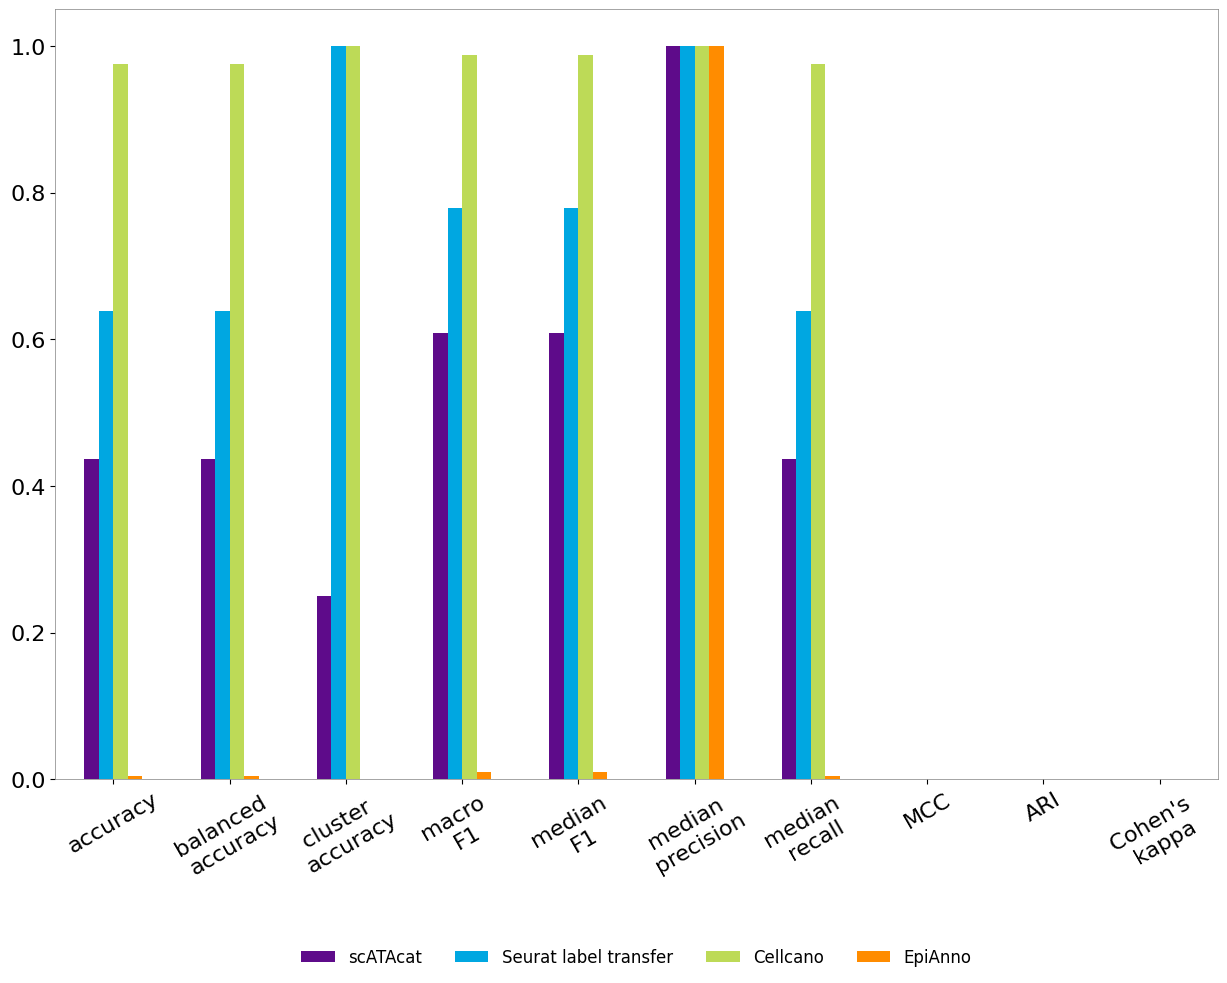

In [71]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_common_annotations.png',x_label_rotation=30 )

## scores only for common cells and common annotations - without EpiAnno

In [72]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations_witho_epianno)]
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)

In [73]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.673455,0.690649,0.6,0.677738,0.606145,0.979661,0.91746,0.605784,0.629645,0.577621
Seurat_label_transfer,0.672748,0.653101,0.533333,0.663616,0.730836,0.832237,0.638469,0.591486,0.469821,0.56571
Cellcano,0.877952,0.873376,0.866667,0.903677,0.956443,0.967128,0.975831,0.850111,0.840161,0.84432


In [74]:
common_annotations

['Mono', 'CLP', 'CD8Tcell', 'NKcell', 'GMP', 'Bcell', 'pDC']

In [75]:
scATAcat_annotations.scATAcat_annotation.value_counts()

scATAcat_annotation
Mono        3903
CD4Tcell    3376
Bcell       1440
GMP          751
CD8Tcell     451
MEP          390
NKcell       315
pDC          299
CLP          236
CMP/LMPP     172
Name: count, dtype: int64

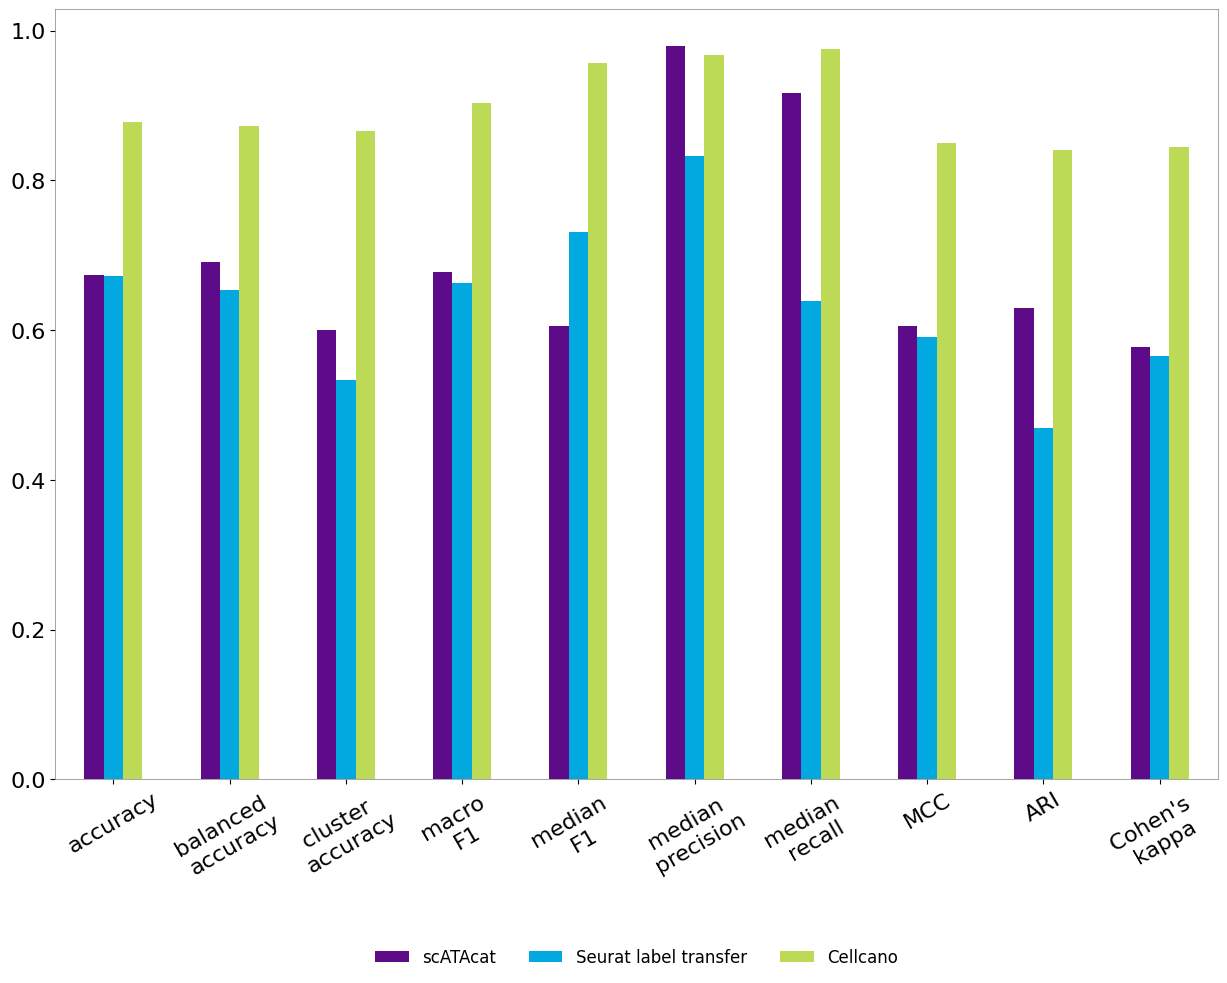

In [76]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_common_annotations_witho_EpiAnno.png',
                         x_label_rotation=30,
                        legend_labels =['scATAcat', 'Seurat label transfer', 'Cellcano'],colors = ['#5E0B8A', '#00A7E1', '#BDDA57'])

## scores for common cells & pairwise common annotations


In [77]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,ground_truth_annotations_known,Cellcano_annotations, EpiAnno_annotations, common_cells=common_cells, cell_ID_column = "cell_IDs")

correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1'
for method in scores_df.index:
    if method == "scATAcat":
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [78]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,cluster_accuracy
scATAcat,0.742026,0.648157,0.620078,0.604878,0.825776,0.91746,0.691212,0.696801,0.676632,0.625000
Seurat_label_transfer,0.298447,0.408491,0.551561,0.551561,0.990843,0.408491,0.307086,0.311773,0.161835,0.166667
Cellcano,0.847783,0.787422,0.743195,0.902315,0.938359,0.916551,0.816461,0.830997,0.811393,0.812500
EpiAnno,0.085199,0.303997,0.05604,0.009843,0.217391,0.005035,-0.12101,0.047664,-0.016475,0.166667


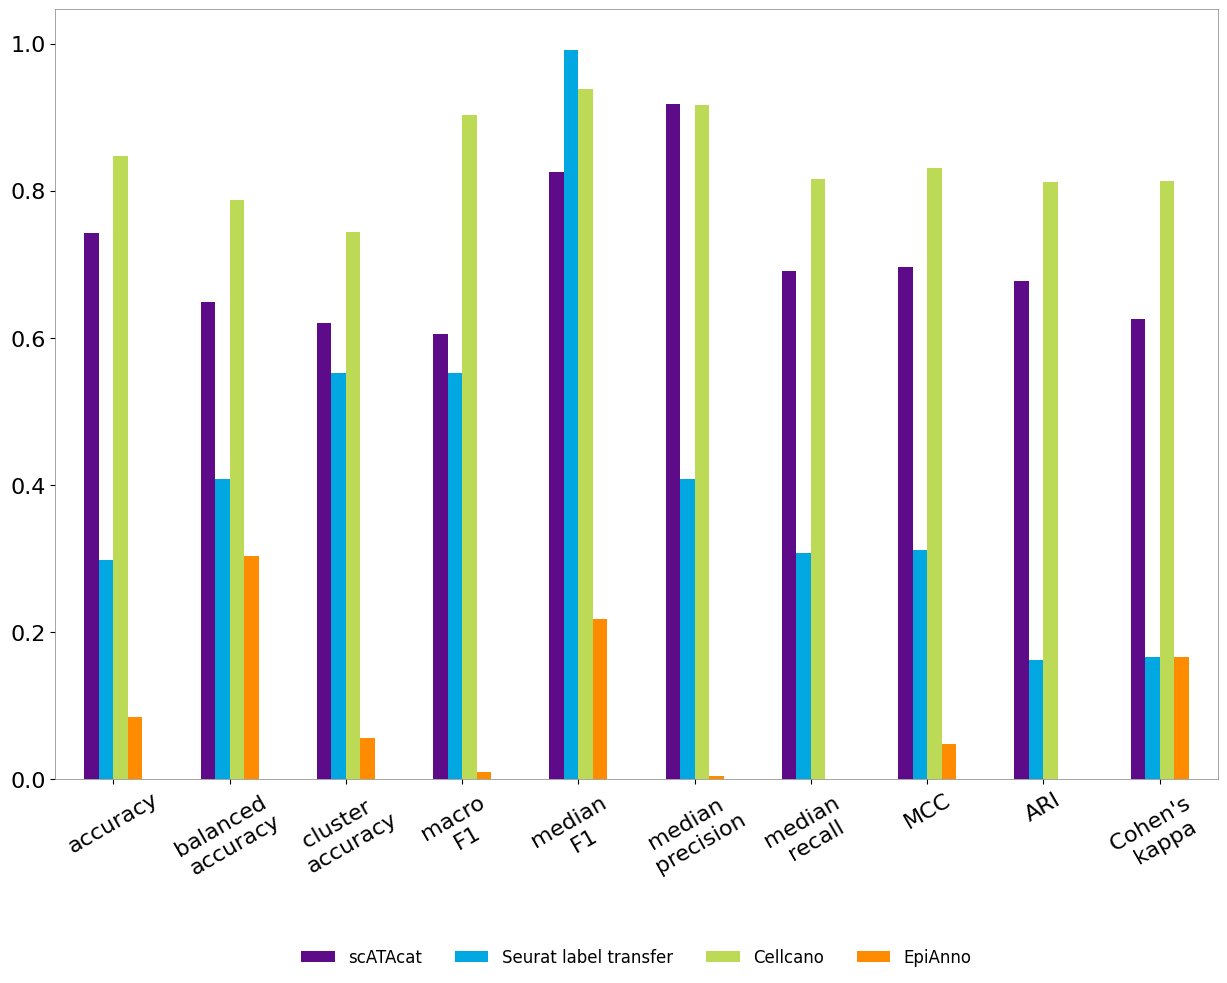

In [79]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_pairwise_common_annotations.png',x_label_rotation=30 )